## Learning portfolio: Exploring a smaller matrix representation of network flows

In [1]:
import numpy as np
import scipy.linalg as la
# import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import random

def plotG(V,E,arrow_length=0.5,arrow_width=0.01,figsize=None):
    V = np.array(V); E = np.array(E);
    if figsize:
        plt.figure(figsize=figsize)
    for e in E:
        i,j = e
        plt.plot([V[i,0],V[j,0]],[V[i,1],V[j,1]],'k')
        plt.arrow(V[i,0],V[i,1],(V[j,0] - V[i,0])*arrow_length,(V[j,1] - V[i,1])*arrow_length,width=arrow_width,color='k')
    plt.plot(V[:,0],V[:,1],'w.',markersize=40,markeredgecolor='k')
    for i in range(V.shape[0]):
        plt.annotate(str(i),xy=V[i,:],ha='center',va='center')
    plt.axis(False)
    plt.show()

During class we modelled network flows using a $ n^2-n $ sized matrix and naturally the question I had was, is it more efficient to just have a $ mxn $ sized matrix? 

My theory is that it won't, because `linprog` knows that those variables must be set to 0 by the constraint on $ u $ and the fact that $u_{ij} = 0$ if there isn't an edge between nodes i and j. If linprog is smart it should zero out those variables at the start and then end up with the exact same reduced matrix that we would get from just considering the edges

Naturally we also want to benchmark this so let's make a function that generates a similar graph to the one used in class
- one center node with n resource
- n outer nodes connected to each other by a cost of 1 
- each outer node is connected to the center node by a random cost

This gives us a not very well connected graph, so by just considering the edges we should have a much smaller matrix

In [2]:
def make_graph(n):
    center = (0,0)
    offset_amt = 4*10 / n
    divisor = n // 4
    V = [center]
    E = []
    def make_pt(corner, offset):
        if corner == 0:
            return (-5 + offset,-5)
        if corner == 1:
            return (5, -5 + offset)
        if corner == 2:
            return (5 - offset, 5)
        if corner == 3:
            return (-5, 5 - offset)

    for i in range(n):
        corner = i // divisor
        offset = offset_amt * (i % divisor)
        V.append(make_pt(corner, offset))
        i += 1
        E.append((0,i)) # center to new edge pt
        if i == 1:
            E.append((i,n)) # previous
        else:
            E.append((i,i-1)) # previous
        if i == n:
            E.append((i,1)) # next
        else:
            E.append((i,i+1)) # next
    return (V, E)

In [3]:
make_graph(8)

([(0, 0),
  (-5.0, -5),
  (0.0, -5),
  (5, -5.0),
  (5, 0.0),
  (5.0, 5),
  (0.0, 5),
  (-5, 5.0),
  (-5, 0.0)],
 [(0, 1),
  (1, 8),
  (1, 2),
  (0, 2),
  (2, 1),
  (2, 3),
  (0, 3),
  (3, 2),
  (3, 4),
  (0, 4),
  (4, 3),
  (4, 5),
  (0, 5),
  (5, 4),
  (5, 6),
  (0, 6),
  (6, 5),
  (6, 7),
  (0, 7),
  (7, 6),
  (7, 8),
  (0, 8),
  (8, 7),
  (8, 1)])

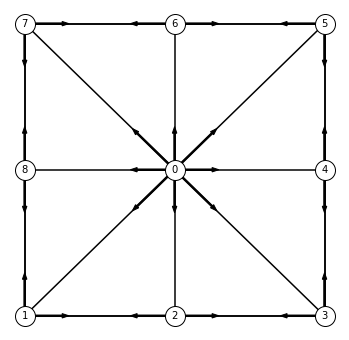

In [4]:
V,E = make_graph(8)
plotG(V,E,arrow_width=0.05,arrow_length=0.25,figsize=(6,6))

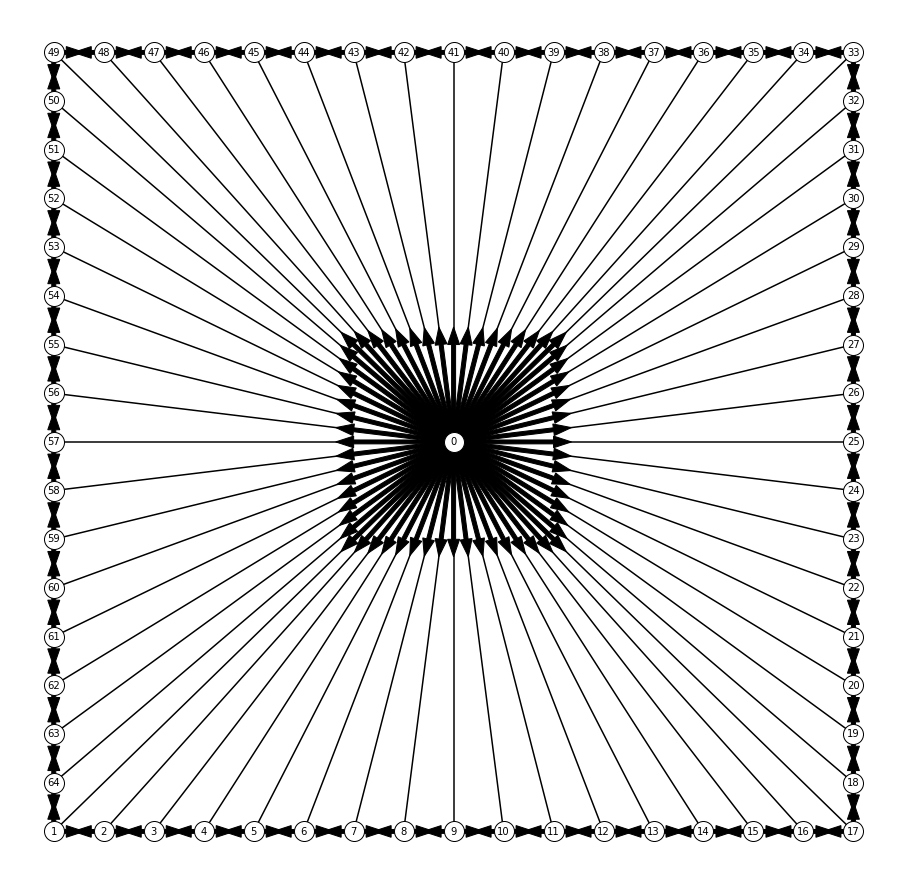

In [19]:
V,E = make_graph(64)
plotG(V,E,arrow_width=0.05,arrow_length=0.25,figsize=(16,16))

In [6]:
def make_costs_big_matrix(n, center_costs):
    # all outer costs are just 1
    c = np.ones((n+1)**2 - n -1)
    # center to outside costs are given by the array
    for i, cost in enumerate(center_costs):
        c[i] = cost
    return c

def make_costs_edges_only_matrix(E, center_costs):
    c = np.zeros(len(E))
    counter = 0
    for i, edge in enumerate(E):
        if edge[0] != 0 and edge[1] != 0:
            # all outer costs are just 1
            c[i] = 1 
        else:
            c[i] = center_costs[counter]
            counter+=1
    return c

In [7]:
n = 8 
V,E = make_graph(n)
print(len(V)) # remember we have n+1 nodes!
center_costs = [random.randint(1,10) for _ in range(n)]
print(center_costs)
print(make_costs_big_matrix(n, center_costs).reshape(n+1,n))
print(E)
print(make_costs_edges_only_matrix(E, center_costs))

9
[2, 5, 6, 5, 2, 7, 3, 10]
[[ 2.  5.  6.  5.  2.  7.  3. 10.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]
[(0, 1), (1, 8), (1, 2), (0, 2), (2, 1), (2, 3), (0, 3), (3, 2), (3, 4), (0, 4), (4, 3), (4, 5), (0, 5), (5, 4), (5, 6), (0, 6), (6, 5), (6, 7), (0, 7), (7, 6), (7, 8), (0, 8), (8, 7), (8, 1)]
[ 2.  1.  1.  5.  1.  1.  6.  1.  1.  5.  1.  1.  2.  1.  1.  7.  1.  1.
  3.  1.  1. 10.  1.  1.]


In [8]:
def make_balance_big_matrix(n):
    n = n + 1
    blocks = []
    for k in range(n):
        block = np.insert(np.eye(n-1),k,-1,axis=0)
        blocks.append(block)
    A = np.hstack(blocks)
    return A

def make_balance_edges_only(n,E):
    A = np.zeros((n+1, len(E)))
    # flows for node #row
    for row in range(n+1):
        for col, edge in enumerate(E):
            if edge[0] == row:
                A[row, col] = -1
            elif edge[1] == row:
                A[row, col] = 1
            else:
                A[row, col] = 0
    return A

In [9]:
n = 8 
V,E = make_graph(n)
# print(make_balance_big_matrix(n))
print(E)
print(make_balance_edges_only(n, E).reshape((n+1, len(E))))

[(0, 1), (1, 8), (1, 2), (0, 2), (2, 1), (2, 3), (0, 3), (3, 2), (3, 4), (0, 4), (4, 3), (4, 5), (0, 5), (5, 4), (5, 6), (0, 6), (6, 5), (6, 7), (0, 7), (7, 6), (7, 8), (0, 8), (8, 7), (8, 1)]
[[-1.  0.  0. -1.  0.  0. -1.  0.  0. -1.  0.  0. -1.  0.  0. -1.  0.  0.
  -1.  0.  0. -1.  0.  0.]
 [ 1. -1. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  1. -1. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1. -1. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1. -1. -1.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1. -1. -1.  0.  1.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1. -1. -1.
   0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   1. -1. -1.  0.  1.  0.]

In [10]:
def make_b(n):
    n = n+1
    b = -np.ones(n)
    b[0] = n-1
    return b

make_b(n)

array([ 8., -1., -1., -1., -1., -1., -1., -1., -1.])

In [11]:
# limit for all flows
limit = 1.5

def make_u_big_matrix(n, E):
    u_big_matrix = np.zeros((n+1)**2 - n -1)
    idx = 0
    for i in range(n+1):
        for j in range(n+1):
            # print(idx, i, j, (i,j) in E)
            if (i,j) in E:
                u_big_matrix[idx] = limit
            if i != j:
                idx += 1
    return u_big_matrix

def make_u_edges_only(E):
    return np.ones(len(E)) * limit

In [12]:
print(make_u_big_matrix(n, E).reshape(n+1,n))

[[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [0.  1.5 0.  0.  0.  0.  0.  1.5]
 [0.  1.5 1.5 0.  0.  0.  0.  0. ]
 [0.  0.  1.5 1.5 0.  0.  0.  0. ]
 [0.  0.  0.  1.5 1.5 0.  0.  0. ]
 [0.  0.  0.  0.  1.5 1.5 0.  0. ]
 [0.  0.  0.  0.  0.  1.5 1.5 0. ]
 [0.  0.  0.  0.  0.  0.  1.5 1.5]
 [0.  1.5 0.  0.  0.  0.  0.  1.5]]


In [13]:
I = np.eye((n+1)**2 - n -1)
c = make_costs_big_matrix(n, center_costs)
u = make_u_big_matrix(n, E)
b = make_b(n)
A = make_balance_big_matrix(n)
solution = linprog(c,A_eq=A[:n-1],b_eq=-b[:n-1],A_ub=I,b_ub=u)
solution.x.round(2).reshape(n+1,n)

array([[1.5 , 1.21, 0.61, 1.31, 1.5 , 0.37, 1.5 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.21, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.17, 0.13, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.63, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [14]:
I = np.eye(len(E))
c = make_costs_edges_only_matrix(E, center_costs)
u = make_u_edges_only(E)
b = make_b(n)
A = make_balance_edges_only(n, E)
solution = linprog(c,A_eq=A[:n-1],b_eq=-b[:n-1],A_ub=I,b_ub=u)
list(zip(solution.x.round(2), E))

[(1.5, (0, 1)),
 (0.5, (1, 8)),
 (0.0, (1, 2)),
 (1.21, (0, 2)),
 (0.0, (2, 1)),
 (0.21, (2, 3)),
 (0.61, (0, 3)),
 (0.0, (3, 2)),
 (0.0, (3, 4)),
 (1.31, (0, 4)),
 (0.17, (4, 3)),
 (0.13, (4, 5)),
 (1.5, (0, 5)),
 (0.0, (5, 4)),
 (0.63, (5, 6)),
 (0.37, (0, 6)),
 (0.0, (6, 5)),
 (0.0, (6, 7)),
 (1.5, (0, 7)),
 (0.0, (7, 6)),
 (0.0, (7, 8)),
 (0.0, (0, 8)),
 (0.0, (8, 7)),
 (0.0, (8, 1))]

In [37]:
def run_big_matrix(n, center_costs):
    V,E = make_graph(n)
    I = np.eye((n+1)**2 - n -1)
    c = make_costs_big_matrix(n, center_costs)
    u = make_u_big_matrix(n, E)
    b = make_b(n)
    A = make_balance_big_matrix(n)
    solution = linprog(c,A_eq=A,b_eq=-b,A_ub=I,b_ub=u)
    solution = solution.x.round(2)

    # recover the flows for each edge and put them into the same order as the edge only model
    idx = 0 
    unordered = {}
    for i in range(n+1):
        for j in range(n+1):
            # print(idx, i, j, (i,j) in E)
            if (i,j) in E:
                unordered[(i,j)] = solution[idx]
            if i != j:
                idx += 1
    ordered = [(unordered[edge], edge) for edge in E]
    return ordered

In [38]:
def run_edges_only_matrix(n, center_costs):
    V,E = make_graph(n)
    I = np.eye(len(E))
    c = make_costs_edges_only_matrix(E, center_costs)
    u = make_u_edges_only(E)
    b = make_b(n)
    A = make_balance_edges_only(n, E)
    solution = linprog(c,A_eq=A,b_eq=-b,A_ub=I,b_ub=u)
    return list(zip(solution.x.round(2), E))

In [39]:
n = 16
center_costs = [random.randint(1,10) for _ in range(n)]
big_soln = run_big_matrix(n, center_costs)
edges_only_soln = run_edges_only_matrix(n, center_costs)
print(big_soln == edges_only_soln)

print(big_soln)
print(edges_only_soln)
# YAY IT WORKS
# now time to benchmark it

True
[(1.5, (0, 1)), (0.71, (1, 16)), (0.0, (1, 2)), (0.71, (0, 2)), (0.21, (2, 1)), (0.0, (2, 3)), (1.5, (0, 3)), (0.5, (3, 2)), (0.0, (3, 4)), (1.5, (0, 4)), (0.0, (4, 3)), (0.5, (4, 5)), (0.0, (0, 5)), (0.0, (5, 4)), (0.0, (5, 6)), (1.5, (0, 6)), (0.5, (6, 5)), (0.0, (6, 7)), (1.5, (0, 7)), (0.0, (7, 6)), (0.5, (7, 8)), (0.0, (0, 8)), (0.0, (8, 7)), (0.0, (8, 9)), (1.5, (0, 9)), (0.5, (9, 8)), (0.0, (9, 10)), (1.5, (0, 10)), (0.0, (10, 9)), (0.5, (10, 11)), (1.5, (0, 11)), (0.0, (11, 10)), (1.0, (11, 12)), (0.0, (0, 12)), (0.0, (12, 11)), (0.0, (12, 13)), (1.5, (0, 13)), (0.0, (13, 12)), (0.5, (13, 14)), (0.29, (0, 14)), (0.0, (14, 13)), (0.0, (14, 15)), (0.0, (0, 15)), (0.21, (15, 14)), (0.0, (15, 16)), (1.5, (0, 16)), (1.21, (16, 15)), (0.0, (16, 1))]
[(1.5, (0, 1)), (0.71, (1, 16)), (0.0, (1, 2)), (0.71, (0, 2)), (0.21, (2, 1)), (0.0, (2, 3)), (1.5, (0, 3)), (0.5, (3, 2)), (0.0, (3, 4)), (1.5, (0, 4)), (0.0, (4, 3)), (0.5, (4, 5)), (0.0, (0, 5)), (0.0, (5, 4)), (0.0, (5, 6)), (1.

<ipython-input-37-c617dfea41c9>:8: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  solution = linprog(c,A_eq=A,b_eq=-b,A_ub=I,b_ub=u)


In [40]:
for i in range(1, 10):
    n = 8*i 
    center_costs = [random.randint(1,10) for _ in range(n)]
    print(f"n = {n}")
    print("big matrix:")
    %timeit run_big_matrix(n, center_costs)
    print("edges only:")
    %timeit run_edges_only_matrix(n, center_costs)

n = 8
big matrix:


<ipython-input-37-c617dfea41c9>:8: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  solution = linprog(c,A_eq=A,b_eq=-b,A_ub=I,b_ub=u)


4.9 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
edges only:
4.22 ms ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
n = 16
big matrix:
17 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
edges only:
12.2 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
n = 24
big matrix:
29.5 ms ± 8.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
edges only:
15.5 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
n = 32
big matrix:
The slowest run took 5.32 times longer than the fastest. This could mean that an intermediate result is being cached.
174 ms ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
edges only:
19.8 ms ± 4.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
n = 40
big matrix:
130 ms ± 51.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
edges only:
28.3 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
n = 48
big matrix:
174 ms ± 32.5 ms per 

Huh, surprisingly the bigger matrix ran much slower than the smaller edge only matrix. I guess that means that `linprog` isn't able to remove the extraneous variables efficiently and ends up quadratically scaling.

That's pretty surprising, I thought for sure `linprog` would be able to just remove the extra rows but I guess not? The runtime for the larger matrix seems to be scaling quadratically as expected though